<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Bet%20Sizing/Bet_sizing_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

In [12]:
!pip install -q ta
import ta

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [151]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, cross_validation

# 1. Bet sizing (probability) - applying meta-labeling

We fit a
classifier, such as an SVC or RF, to determine the probability of misclassification, and
use that probability to derive the bet size.

### WHY do we use meta-labeling for sizing the bet?

Advantages
1. The ML algorithm that decides the bet sizes is independent of the primary model, allowing for the incorporation of features predictive of false positives (see below). 

2. The predicted probability can be directly translated into bet size.

### What is meta labeling?

Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is **how much money we should risk in such a bet**. We do not want the ML algorithm to learn the side, just
to tell us what is the **appropriate size**. We want to build a **secondary ML model** that learns how to use a primary exogenous model.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine **whether we should act or pass
on the opportunity that has been presented.**



Advantages of meta-labeling

First, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. 

Second, the effects of overfitting are limited when you apply meta labeling,
because ML will not decide the side of your bet, only the size. 

Third, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the sell recommendations of an entirely different primary model. 

Fourth, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. - Bet Sizing

Four steps


1. Use your forecasts from the primary model, and generate meta-labels. Remember, horizontal barriers do not need to be symmetric in this case.

2. Fit your model again on the same training set, but this time using the meta-labels you just generated.

3. Combine the “sides” from the first ML model with the “sizes” from the second ML model. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

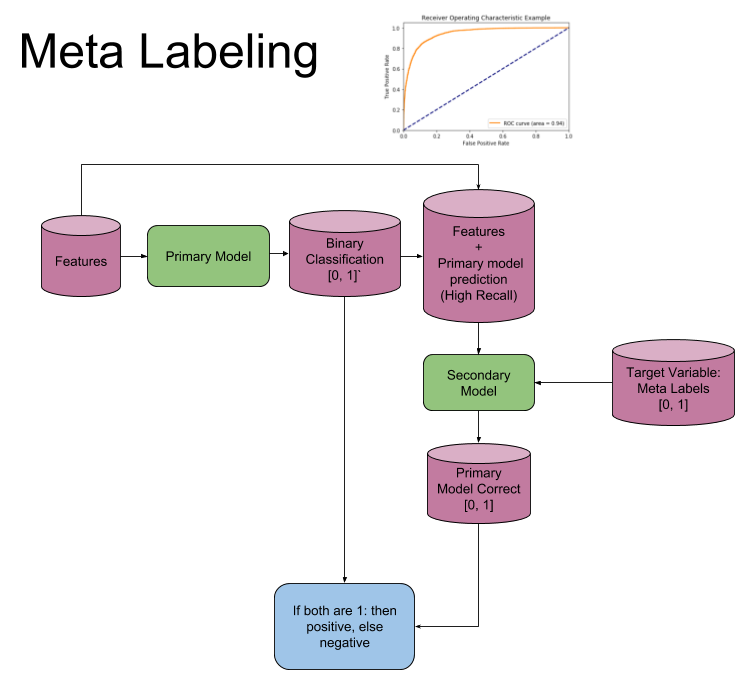

In [6]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

### Steps 


https://hudsonthames.org/does-meta-labeling-add-to-signal-efficacy-triple-barrier-method/

1. Compute long short signals for the strategy. For instance, in the mean-reverting strategy, generate a long signal when the close price is below the lower Bollinger band and create a sell signal if the close price is higher than the upper Bollinger band. We call this the “Primary model”.

2. Get time stamps of the events using CUSUM (or cumulative sum control chart) filter and point estimate of the volatility. See section 4.2.
Determine events when one of the three exit points (profit taking, stop-loss and vertical barrier) occur. Advances in Financial Machine Learning discusses this in Chapter 3. The result of this step is a trade decision – long or short, or 1 or -1.

3. Determine the bet size. The prior step tell us the direction of the trade. This step says if we should trade or not – a one or zero decision.
Tune the hyper-parameters (max_depth and n_estimators) of Random Forest using grid search and cross-validation. We keep the random state constant for reproducibility of the results.

4. Train a machine-learning algorithm (we use Random Forest for illustration) with new features like one to five day serial correlations, one to five-day returns, 50-day volatility, and 14-day RSI. We iterate over this step number of times until we see in-sample results that are acceptable. In other words, we only exit this step when we consider the model to be ready and there is no turning back.

5. Evaluate the performance of in sample and out-of-sample or this meta-model model.
Evaluate the performance of the “Primary model”
Compare the performance of the meta-model and the primary model

### Read in data - dollar bars

E-mini S&P Future tick data

In [305]:
# make dollar bars from tick data
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=100_000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [306]:
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:32:06,8,50.79,50.7900,50.7100,50.7800,2338,1600,8,118655.9800
2009-09-28 09:33:54,16,50.78,50.8226,50.7800,50.8200,1998,1098,8,101525.6200
2009-09-28 09:37:33,24,50.82,50.8500,50.8000,50.8299,2066,866,8,105001.5634
2009-09-28 09:41:53,35,50.81,50.8400,50.7833,50.8400,2142,400,11,108836.0704
2009-09-28 09:44:09,41,50.85,50.9100,50.8300,50.9100,2000,1700,6,101767.0000


In [307]:
len(dollar_bars)

347844

In [0]:
close = dollar_bars.close

Why do we use dollar bars?

See Chapter 2

### 1. Train a primary model (which decides 'sides') 

- Based on the simple moving average cross-over strategy.

In [0]:
fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

side = df['side']

In [0]:
side.value_counts()

 1.0    32190
-1.0    26367
Name: side, dtype: int64

- Based on the mean-reverting Bollinger band strategy.

In [0]:
n=50

df = pd.DataFrame()

df['lower'] = ta.volatility.bollinger_lband(close,n)
df['upper'] = ta.volatility.bollinger_hband(close,n)
df['close'] = close
df['side'] = np.nan

long_signals = (df['close'] <= df['lower']) 
short_signals = (df['close'] >= df['upper']) 

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

side = df['side']

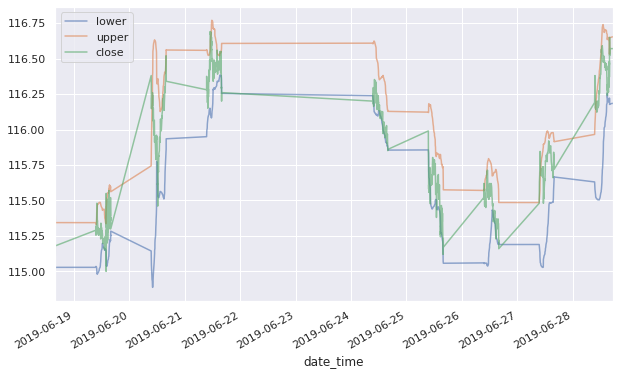

In [310]:
f,ax=plt.subplots(figsize=(10,6))
df.iloc[-1000:,:3].plot( alpha=0.6 ,ax=ax)

In [311]:
side.value_counts()

 1.0    24771
-1.0    24471
Name: side, dtype: int64

### 2. Generate labels (from a primary model)

Get time stamps of the events using CUSUM filter and point estimate of the volatility.

In [0]:
# form a tripple-barrier
pt_sl = [1,2]

target = util.get_daily_vol(close,lookback=100)

h = target.mean()*0.5
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_events

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=1)

In [313]:
# events
min_ret = 0.0025

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)

# label (bin) - binary classification from the primary model

bin = labeling.get_bins(events, close)

2020-01-30 15:24:30.428864 100.0% apply_pt_sl_on_t1 done after 0.94 minutes. Remaining 0.0 minutes.


In [314]:
bin.head()

,ret,trgt,bin,side
2009-09-29 09:59:17,NaN,0.002765,0,NaN
2009-09-29 10:00:21,NaN,0.002991,0,NaN
2009-09-29 10:02:38,NaN,0.004096,0,NaN
2009-09-29 10:11:36,NaN,0.004886,0,NaN
2009-09-29 10:24:50,NaN,0.004375,0,NaN


In [0]:
bin.dropna(inplace=True)

In [316]:
bin.side.value_counts()

 1.0    1841
-1.0    1497
Name: side, dtype: int64

In [317]:
bin.bin.value_counts()

0    1799
1    1539
Name: bin, dtype: int64

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1799
           1       0.46      1.00      0.63      1539

    accuracy                           0.46      3338
   macro avg       0.23      0.50      0.32      3338
weighted avg       0.21      0.46      0.29      3338

Accuracy =  0.4610545236668664

Confusion Matrix


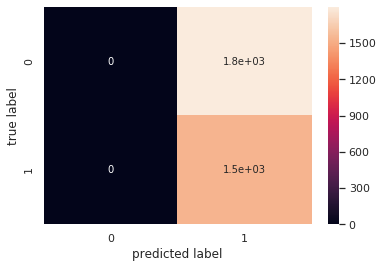

In [318]:
primary_forecast = pd.DataFrame(bin['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

print(classification_report(actual, pred))

print("Accuracy = ", accuracy_score(actual,pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(actual, pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

### 3. Features



Features - Kara et al. (2011)


- Simple 10-day moving average
- Weighted 10-day moving average
- Momentum
- Stochastic K%
- Stochastic D%
- RSI (Relative Strength Index)
- MACD (moving average convergence divergence)
- Larry William’s R% 
- A/D (Accumulation/Distribution) Oscillator
- CCI (Commodity Channel Index)

https://github.com/bukosabino/ta

In [319]:
bars = dollar_bars.iloc[:,1:6]
bars.head()

,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:32:06,50.79,50.7900,50.7100,50.7800,2338
2009-09-28 09:33:54,50.78,50.8226,50.7800,50.8200,1998
2009-09-28 09:37:33,50.82,50.8500,50.8000,50.8299,2066
2009-09-28 09:41:53,50.81,50.8400,50.7833,50.8400,2142
2009-09-28 09:44:09,50.85,50.9100,50.8300,50.9100,2000


Volume
- Accumulation/Distribution Index (ADI)
-On-Balance Volume (OBV)
-Chaikin Money Flow (CMF)
-Force Index (FI)
-Ease of Movement (EoM, EMV)
-Volume-price Trend (VPT)
-Negative Volume Index (NVI)

Volatility
- Average True Range (ATR)
- Bollinger Bands (BB)
- Keltner Channel (KC)
- Donchian Channel (DC)

Trend
- Moving Average Convergence Divergence (MACD)
- Average Directional Movement Index (ADX)
- Vortex Indicator (VI)
- Trix (TRIX)
- Mass Index (MI)
- Commodity Channel Index (CCI)
- Detrended Price Oscillator (DPO)
- KST Oscillator (KST)
- Ichimoku Kinkō Hyō (Ichimoku)
- Parabolic Stop And Reverse (Parabolic SAR)

Momentum
- Money Flow Index (MFI)
- Relative Strength Index (RSI)
- True strength index (TSI)
- Ultimate Oscillator (UO)
- Stochastic Oscillator (SR)
- Williams %R (WR)
- Awesome Oscillator (AO)
- Kaufman's Adaptive Moving Average (KAMA)
- Rate of Change (ROC)

Others
- Daily Return (DR)
- Daily Log Return (DLR)
- Cumulative Return (CR)

In [0]:
ta_features = ta.add_all_ta_features(bars,'open','high','low','close','volume')

In [321]:
#look-ahead bias
ta_features = ta_features.shift(1)

ta_features.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-09-28 09:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-28 09:33:54,50.79,50.7900,50.7100,50.7800,2338.0,1753.500000,2338.0,0.750000,NaN,NaN,NaN,-1010.117414,1000.000000,0.0,50.780000,50.78000,50.780000,0.000000,0.0,0.0,50.760000,50.760000,50.680000,0.0,0.0,50.78,50.7800,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,38.631151,-432.061892,-432.061892,0.000000,50.7500,50.7500,89.407103,89.398168,4.0,4.0,0.0,50.78,NaN,NaN,0.0,0.0,100.0,NaN,NaN,NaN,87.500000,87.500000,-12.500000,0.0,NaN,NaN,-43.206189,NaN,0.000000
2009-09-28 09:37:33,50.78,50.8226,50.7800,50.8200,1998.0,3507.612676,4336.0,0.808951,NaN,109.378378,109.378378,-1008.586857,1000.787712,0.0,50.800000,50.84000,50.760000,0.080000,0.0,0.0,50.783767,50.783767,50.722467,0.0,0.0,50.78,50.8200,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,66.666667,38.611151,-431.838207,-431.950050,0.111843,50.7663,50.7663,89.407103,89.398168,8.0,4.0,4.0,50.82,NaN,NaN,0.0,0.0,100.0,NaN,100.0,NaN,97.690941,92.595471,-2.309059,0.0,NaN,NaN,0.078771,0.078740,0.078771
2009-09-28 09:41:53,50.82,50.8500,50.8000,50.8299,2066.0,3912.548676,6402.0,0.611145,NaN,57.357212,83.367795,1.976316,1000.787712,0.0,50.809967,50.85311,50.766823,0.086287,0.0,0.0,50.798056,50.798056,50.740522,0.0,0.0,50.78,50.8299,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,75.094891,38.601185,-431.726737,-431.875612,0.148875,50.7800,50.7800,89.407103,89.398168,12.0,4.0,8.0,50.79,NaN,50.79,0.0,1.0,100.0,NaN,100.0,NaN,85.642857,90.277933,-14.357143,0.0,NaN,NaN,0.019481,0.019479,0.098267
2009-09-28 09:44:09,50.81,50.8400,50.7833,50.8400,2142.0,6054.548676,8544.0,0.708632,NaN,-35.338235,43.799118,0.828087,1000.787712,0.0,50.817475,50.86300,50.771950,0.091050,0.0,0.0,50.803817,50.803817,50.746492,0.0,0.0,50.78,50.8400,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,52.592874,38.593676,-431.642761,-431.817399,0.174638,50.7800,50.7800,89.407103,89.398168,16.0,4.0,12.0,50.80,50.8,NaN,1.0,0.0,100.0,NaN,100.0,NaN,92.857143,92.063647,-7.142857,0.0,NaN,NaN,0.019870,0.019868,0.118157


In [322]:
ta_features.columns

Index(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
   

In [0]:
ta_features_3 = ta_features.loc[:, ['volume_adi', 'volatility_atr', 'trend_macd',
                    'trend_cci', 'momentum_rsi', 'momentum_stoch', 'momentum_kama']]

In [324]:
ta_features_3 = ta_features_3.dropna(axis=1,how='any',thresh=len(ta_features)-20)
ta_features_3 = ta_features_3.dropna()
ta_features_3

,volume_adi,volatility_atr,trend_cci,momentum_rsi,momentum_stoch
date_time,,,,,
2009-09-28 09:37:33,3507.612676,0.000000,66.666667,100.000000,97.690941
2009-09-28 09:41:53,3912.548676,0.000000,75.094891,100.000000,85.642857
2009-09-28 09:44:09,6054.548676,0.000000,52.592874,100.000000,92.857143
2009-09-28 09:45:02,8054.548676,0.000000,147.444218,100.000000,100.000000
2009-09-28 09:46:34,10156.548676,0.000000,157.907605,100.000000,100.000000
...,...,...,...,...,...
2019-06-28 15:59:35,-392122.253007,0.031394,31.744030,57.430666,43.478261
2019-06-28 15:59:46,-393300.253007,0.030255,13.393899,54.273821,31.818182
2019-06-28 15:59:59,-392319.253007,0.031229,32.938847,59.114372,50.000000


In [0]:
raw_data = pd.DataFrame(close)

log_ret = np.log(raw_data['close']).diff()

raw_data['sma10'] = raw_data['close'].rolling(window = 10).mean()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)

'''# Volatility
raw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()'''

# Serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [0]:
raw_X = raw_data.join(ta_features_3)
raw_X = raw_X.iloc[:,1:]
raw_X.dropna(inplace=True)

In [333]:
raw_X.head()

,sma10,mom1,mom2,mom3,autocorr_1,autocorr_2,autocorr_3,volume_adi,volatility_atr,trend_cci,momentum_rsi,momentum_stoch
date_time,,,,,,,,,,,,
2009-09-28 10:30:08,51.23457,-0.000244,-0.000390,-0.000390,0.111248,-0.019038,-0.091295,16414.286212,0.022530,-49.954509,53.022695,41.57741
2009-09-28 10:31:09,51.23966,0.001171,0.000927,0.000780,0.090115,-0.034099,-0.135601,18669.286212,0.026277,126.129771,62.820619,100.00000
2009-09-28 10:31:44,51.24886,0.000195,0.001366,0.001122,0.088609,-0.037041,-0.153285,21056.286212,0.025209,158.448681,64.162212,100.00000
2009-09-28 10:31:45,51.26086,0.000975,0.001170,0.002342,0.089802,-0.001398,-0.172220,23757.286212,0.027688,249.120047,69.992645,100.00000
2009-09-28 10:32:01,51.27625,0.000000,0.000975,0.001170,-0.025007,-0.055019,-0.172808,23757.286212,0.024919,222.923841,69.992645,100.00000


PCA

In [327]:
# Feature decomposition PCA

n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)
'''

# No PCA
X = raw_X.copy()'''

'\n\n# No PCA\nX = raw_X.copy()'

In [0]:
X['side'] = side

In [0]:
ffd = features.fracdiff.frac_diff_ffd(close.to_frame(),0.4)

In [0]:
X['ffd'] = ffd

In [0]:
X.dropna(inplace=True)

In [332]:
X.head()

,0,1,2,3,4,side,ffd
date_time,,,,,,,
2009-10-14 15:08:13,-1.917113e+06,-307.305743,-25.302772,-43.674973,-7.883854,-1.0,2.073613
2009-10-14 15:13:06,-1.917764e+06,-288.324497,-25.334982,-41.051055,-5.940096,-1.0,2.119104
2009-10-14 15:15:36,-1.915884e+06,-273.208339,-25.512498,-25.926891,-0.548038,-1.0,2.081060
2009-10-14 15:19:32,-1.916862e+06,-221.317225,-25.569126,-23.445491,2.326327,-1.0,2.102613
2009-10-14 15:21:12,-1.914678e+06,-188.694123,-25.848036,-0.989677,5.651096,-1.0,2.084311


In [334]:
len(X)

49038

### 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [0]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [337]:
X

,0,1,2,3,4,side,ffd
date_time,,,,,,,
2009-10-14 15:29:13,-1.913487e+06,-136.065482,-25.935560,5.968497,9.982708,-1.0,2.150243
2009-10-15 11:02:54,-1.927254e+06,261.422908,-26.535728,23.061083,6.513996,1.0,2.080379
2009-10-16 10:01:16,-1.935420e+06,109.187313,-26.114443,-26.328356,-11.656158,1.0,1.777919
2009-10-19 09:29:30,-1.945376e+06,-115.269290,-26.295827,19.136093,5.838311,-1.0,1.955723
2009-10-19 10:46:14,-1.938132e+06,-186.666783,-25.918517,-4.256254,-2.325876,-1.0,2.090380
...,...,...,...,...,...,...,...
2019-06-14 14:18:53,-2.635556e+06,-197.271422,39.942346,-4.139491,-4.866260,-1.0,4.296596
2019-06-14 15:22:45,-2.639933e+06,-197.370252,40.286017,-10.587377,11.731790,-1.0,4.368976
2019-06-18 09:39:40,-2.637934e+06,-197.796451,39.602271,-9.009322,11.037225,-1.0,4.584617


In [0]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

In [340]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), close, 3).mean()
max_samples = avgU[0]
max_samples

2020-01-30 15:43:58.918647 100.0% num_concurrent_events done after 0.04 minutes. Remaining 0.0 minutes.
2020-01-30 15:44:01.041589 100.0% _get_average_uniqueness done after 0.03 minutes. Remaining 0.0 minutes.


0.6113867866821324

In [341]:
clf0 = RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, max_features=1, n_estimators=1000)
clf1.fit(X_train, y_train.values.ravel())

#this is the method in the book

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_frac

In [379]:
parameters = {'max_depth':[2, 3, 5, 7],
              'n_estimators':[100, 512, 1000]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=3)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=0.6113867866821324,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                   

In [380]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       max_samples=0.6113867866821324,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train metrics

In [0]:
y_pred_prob_0 = clf1.predict_proba(X_train)[:, 1]
y_pred_0 = clf1.predict(X_train)

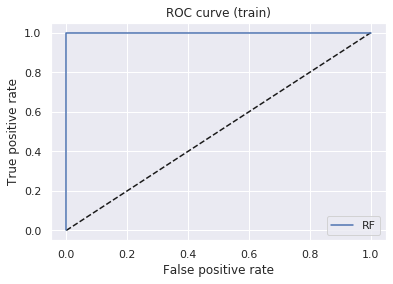

In [393]:
fpr_rf_0, tpr_rf_0, _ = roc_curve(y_train, y_pred_prob_0)

%matplotlib inline

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_0, tpr_rf_0, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (train)')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1113
         1.0       1.00      1.00      1.00       877

    accuracy                           1.00      1990
   macro avg       1.00      1.00      1.00      1990
weighted avg       1.00      1.00      1.00      1990

Accuracy =  0.9994974874371859

Confusion Matrix


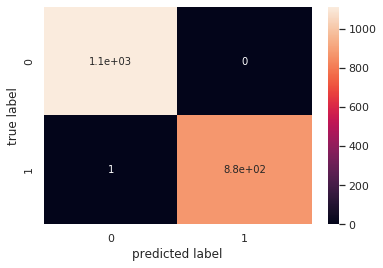

In [394]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [0]:
y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)[:, 1]

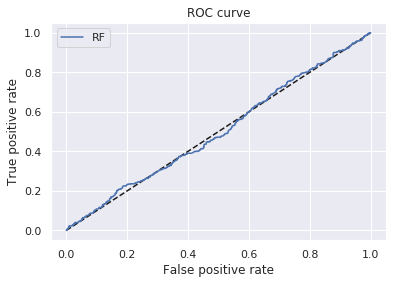

In [396]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob)

%matplotlib inline

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       0.51      0.77      0.61       674
         1.0       0.50      0.25      0.33       653

    accuracy                           0.51      1327
   macro avg       0.51      0.51      0.47      1327
weighted avg       0.51      0.51      0.47      1327

Accuracy =  0.5094197437829691

Confusion Matrix


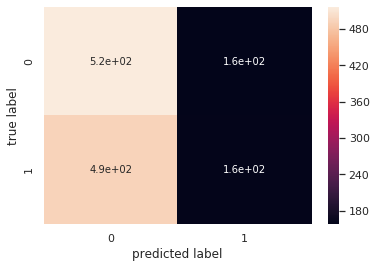

In [397]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

### Bet Sizing

When num_classes = 2,

$$z = \frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$m = 2Z [z] − 1$$

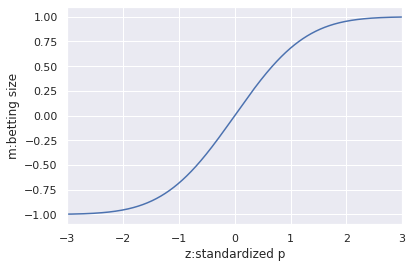

In [350]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(z,m)
plt.xlim(-3,3)
plt.xlabel('z:standardized p');
plt.ylabel('m:betting size');

In [0]:
from mlfinlab import bet_sizing as bs

In [0]:
p = y_pred_prob # from RF (secondary model)

In [353]:
new_data = y_test.copy()
new_data['p'] = p
new_data['pred'] = y_pred
new_data

,bin,p,pred
date_time,,,
2015-03-30 09:42:26,0.0,0.341543,0.0
2015-03-31 15:15:12,0.0,0.445436,0.0
2015-04-01 09:43:15,1.0,0.381436,0.0
2015-04-02 09:49:29,1.0,0.367543,0.0
2015-04-02 09:54:02,1.0,0.392543,0.0
...,...,...,...
2019-06-14 14:18:53,1.0,0.358543,0.0
2019-06-14 15:22:45,1.0,0.408543,0.0
2019-06-18 09:39:40,0.0,0.386543,0.0


In [0]:
# test에 맞추자
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [355]:
bs_df

,t1,trgt,side,pt,sl,bin,p,pred
date_time,,,,,,,,
2015-03-30 09:42:26,2015-03-31 09:44:08,0.004149,-1.0,1,2,0.0,0.341543,0.0
2015-03-31 15:15:12,2015-04-01 15:16:36,0.005690,1.0,1,2,0.0,0.445436,0.0
2015-04-01 09:43:15,2015-04-01 11:14:25,0.005201,1.0,1,2,1.0,0.381436,0.0
2015-04-02 09:49:29,2015-04-06 09:30:00,0.003821,-1.0,1,2,1.0,0.367543,0.0
2015-04-02 09:54:02,2015-04-06 09:30:00,0.004848,-1.0,1,2,1.0,0.392543,0.0
...,...,...,...,...,...,...,...,...
2019-06-14 14:18:53,2019-06-17 09:29:59,0.003587,-1.0,1,2,1.0,0.358543,0.0
2019-06-14 15:22:45,2019-06-17 09:29:59,0.003128,-1.0,1,2,1.0,0.408543,0.0
2019-06-18 09:39:40,2019-06-18 11:02:21,0.003985,-1.0,1,2,0.0,0.386543,0.0


In [0]:
m_prob = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3)

In [357]:
m_prob

date_time
2015-03-30 09:42:26   -0.261724
2015-03-31 15:15:12   -0.087419
2015-04-01 09:43:15   -0.192839
2015-04-02 09:49:29   -0.216476
2015-04-02 09:54:02   -0.174172
                         ...   
2019-06-14 14:18:53   -0.231979
2019-06-14 15:22:45   -0.147596
2019-06-18 09:39:40   -0.184232
2019-06-18 09:41:48   -0.284924
2019-06-18 09:48:22   -0.431023
Name: signal, Length: 1327, dtype: float64

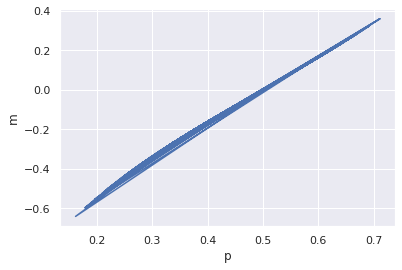

In [358]:
plt.plot(p, m_prob)
plt.xlabel('p');
plt.ylabel('m');

average

In [359]:

m_prob_avg = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True)
m_prob_avg = m_prob_avg.loc[bs_df.index]

2020-01-30 15:45:05.268451 100.0% mp_avg_active_signals done after 0.1 minutes. Remaining 0.0 minutes.


In [360]:
m_prob_avg

date_time
2015-03-30 09:42:26   -0.261724
2015-03-31 15:15:12   -0.087419
2015-04-01 09:43:15   -0.140129
2015-04-02 09:49:29   -0.216476
2015-04-02 09:54:02   -0.195324
                         ...   
2019-06-14 14:18:53   -0.144413
2019-06-14 15:22:45   -0.189788
2019-06-18 09:39:40   -0.184232
2019-06-18 09:41:48   -0.234578
2019-06-18 09:48:22   -0.300060
Length: 1327, dtype: float64

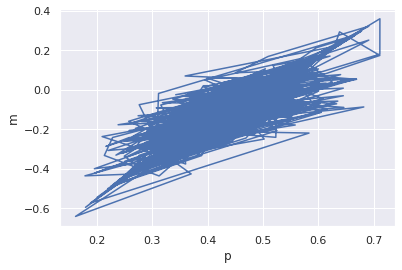

In [361]:
plt.plot(p, m_prob_avg)
plt.xlabel('p');
plt.ylabel('m');

discrete

In [362]:
m_prob_discrete = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True, step_size=0.01)
m_prob_discrete = m_prob_discrete.loc[bs_df.index]

2020-01-30 15:45:11.677736 100.0% mp_avg_active_signals done after 0.1 minutes. Remaining 0.0 minutes.


In [363]:
m_prob_discrete

date_time
2015-03-30 09:42:26   -0.26
2015-03-31 15:15:12   -0.09
2015-04-01 09:43:15   -0.14
2015-04-02 09:49:29   -0.22
2015-04-02 09:54:02   -0.20
                       ... 
2019-06-14 14:18:53   -0.14
2019-06-14 15:22:45   -0.19
2019-06-18 09:39:40   -0.18
2019-06-18 09:41:48   -0.23
2019-06-18 09:48:22   -0.30
Length: 1327, dtype: float64

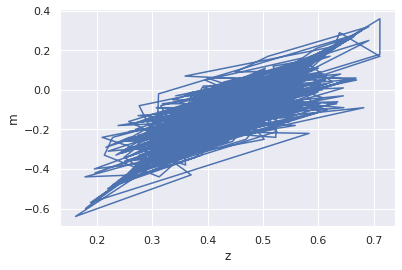

In [364]:
plt.plot(p, m_prob_discrete)
plt.xlabel('z');
plt.ylabel('m');

# Bet Sizing (reserve)

$c_t = c_{t,l} - c_{t,s} $ 

where $c_{t,l}$ is the number of concurrent long bets at
time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

where $F[x]$ is CDF of the fitted mixture of two Gaussians for a value x.

EF3M Algorithm



https://github.com/hudson-and-thames/research/blob/master/Chapter10/ef3m_testing.ipynb

In [365]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)

|#########################| Completed 25 of 25 fitting rounds.

In [366]:
m_reserve[0]

,t1,side,active_long,active_short,c_t,bet_size
date_time,,,,,,
2015-03-30 09:42:26,2015-03-31 09:44:08,-1.0,0,1,-1,-0.444139
2015-03-31 15:15:12,2015-04-01 15:16:36,1.0,1,0,1,0.391913
2015-04-01 09:43:15,2015-04-01 11:14:25,1.0,2,0,2,0.709847
2015-04-02 09:49:29,2015-04-06 09:30:00,-1.0,0,1,-1,-0.444139
2015-04-02 09:54:02,2015-04-06 09:30:00,-1.0,0,2,-2,-0.762474
...,...,...,...,...,...,...
2019-06-14 14:18:53,2019-06-17 09:29:59,-1.0,1,1,0,0.000000
2019-06-14 15:22:45,2019-06-17 09:29:59,-1.0,0,2,-2,-0.762474
2019-06-18 09:39:40,2019-06-18 11:02:21,-1.0,0,1,-1,-0.444139


In [0]:
BetSizeReserve = m_reserve[0].bet_size

In [368]:
m_reserve[1]
#parameter for two Gaussian mixture

{'mu_1': -0.5755,
 'mu_2': 1.3866,
 'p_1': 0.60401,
 'sigma_1': 1.5169,
 'sigma_2': 1.40241}

# Bet sizing (budget)

$$ m_t = c_{t,l}\frac{1}{max_i[c_{i,l}]} − c_{t,s}\frac{1}{max_i[c_{i,s}]} $$

In [369]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
date_time,,,,,
2015-03-30 09:42:26,2015-03-31 09:44:08,-1.0,0,1,-0.166667
2015-03-31 15:15:12,2015-04-01 15:16:36,1.0,1,0,0.142857
2015-04-01 09:43:15,2015-04-01 11:14:25,1.0,2,0,0.285714
2015-04-02 09:49:29,2015-04-06 09:30:00,-1.0,0,1,-0.166667
2015-04-02 09:54:02,2015-04-06 09:30:00,-1.0,0,2,-0.333333
...,...,...,...,...,...
2019-06-14 14:18:53,2019-06-17 09:29:59,-1.0,1,1,-0.023810
2019-06-14 15:22:45,2019-06-17 09:29:59,-1.0,0,2,-0.333333
2019-06-18 09:39:40,2019-06-18 11:02:21,-1.0,0,1,-0.166667


In [0]:
BetSizeBudget = m_budget.bet_size

# Overview

In [450]:
bet_size_0 = pd.DataFrame({'BetSizeProb':m_prob,'BetSizeProbAvg':m_prob_avg,'BetSizeProbDiscrete':m_prob_discrete})
bet_size_1 = bet_size_0.join(BetSizeReserve)
bet_size = bet_size_1.join(BetSizeBudget,rsuffix='2')
bet_size = bet_size.rename(columns={'bet_size':'BetSizeReserve', 'bet_size2':'BetSizeBudget'})
bet_size['NoSize'] = bs_df.side*bs_df.bin
bet_size.head()

,BetSizeProb,BetSizeProbAvg,BetSizeProbDiscrete,BetSizeReserve,BetSizeBudget,NoSize
date_time,,,,,,
2015-03-30 09:42:26,-0.261724,-0.261724,-0.26,-0.444139,-0.166667,-0.0
2015-03-31 15:15:12,-0.087419,-0.087419,-0.09,0.391913,0.142857,0.0
2015-04-01 09:43:15,-0.192839,-0.140129,-0.14,0.709847,0.285714,1.0
2015-04-02 09:49:29,-0.216476,-0.216476,-0.22,-0.444139,-0.166667,-1.0
2015-04-02 09:54:02,-0.174172,-0.195324,-0.20,-0.762474,-0.333333,-1.0


In [0]:
bet_size.dropna(inplace=True)

Plot

Text(0.5, 1.0, 'Bet Size 100 points')

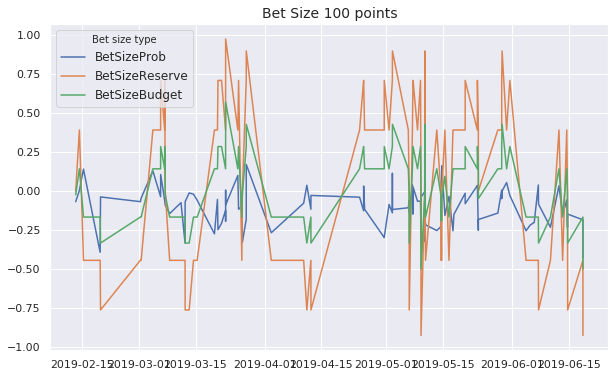

In [453]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_3 = bet_size.drop(['BetSizeProbAvg','BetSizeProbDiscrete','NoSize'],axis=1)
ax.plot(bet_size_3[-100:])

ax.legend(labels=bet_size_3.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Prob 100 points')

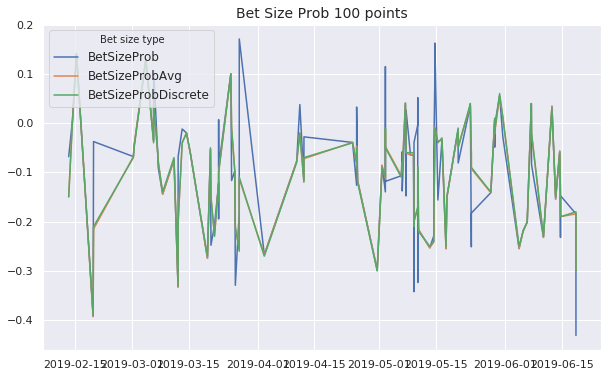

In [454]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_4 = bet_size.iloc[:,:3]
ax.plot(bet_size_4[-100:])

ax.legend(labels=bet_size_4.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size Prob 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

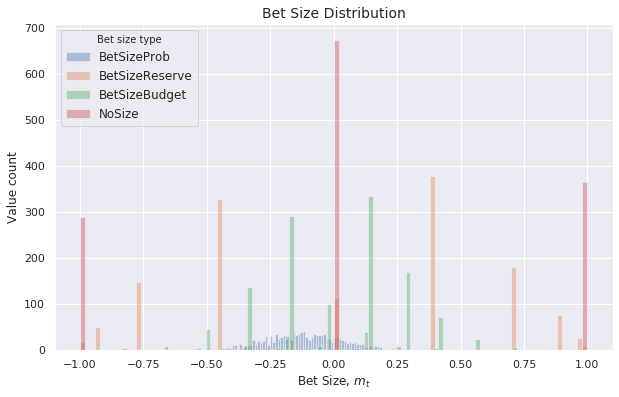

In [457]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProb','BetSizeReserve', 'BetSizeBudget','NoSize']:
    ax.hist(bet_size[c],  label=c, alpha=0.4, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

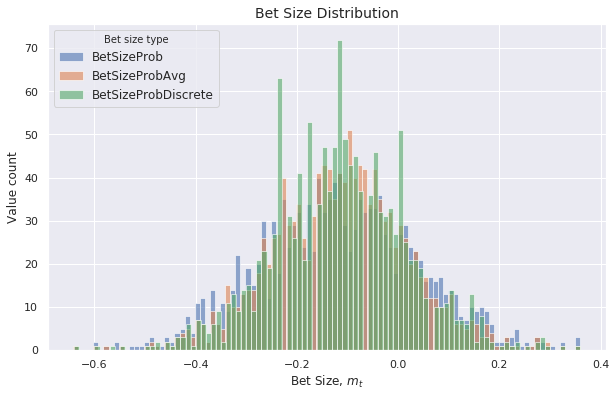

In [376]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProb','BetSizeProbAvg', 'BetSizeProbDiscrete']:
    ax.hist(bet_size_4[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

## profit

In [0]:
data_profit = bet_size.copy()
data_profit['NoSize'] = (bs_df.side*bs_df.bin).loc[bet_size.index] 
data_profit['close'] = close.loc[bet_size.index]

In [443]:
data_profit.head()

,BetSizeProb,BetSizeProbAvg,BetSizeProbDiscrete,BetSizeReserve,BetSizeBudget,NoSize,close
date_time,,,,,,,
2015-03-30 09:42:26,-0.261724,-0.261724,-0.26,-0.444139,-0.166667,-0.0,92.9100
2015-03-31 15:15:12,-0.087419,-0.087419,-0.09,0.391913,0.142857,0.0,92.6299
2015-04-01 09:43:15,-0.192839,-0.140129,-0.14,0.709847,0.285714,1.0,91.9600
2015-04-02 09:49:29,-0.216476,-0.216476,-0.22,-0.444139,-0.166667,-1.0,92.6000
2015-04-02 09:54:02,-0.174172,-0.195324,-0.20,-0.762474,-0.333333,-1.0,92.8300


In [0]:
mprob = data_profit.BetSizeProb
mproba = data_profit.BetSizeProbAvg
mprobd = data_profit.BetSizeProbDiscrete
mres = data_profit.BetSizeReserve
mbudg = data_profit.BetSizeBudget
mclose = data_profit.close
mnosize = data_profit.NoSize

In [0]:
bet_profit = pd.DataFrame()
bet_profit['Prob'] = -mprob*mclose
bet_profit['ProbAvg'] = -mproba*mclose
bet_profit['ProbDiscrete'] = -mprobd*mclose
bet_profit['Reserve'] = -mres*mclose
bet_profit['Budget'] = -mbudg*mclose
bet_profit['NoSize'] = -mnosize*mclose

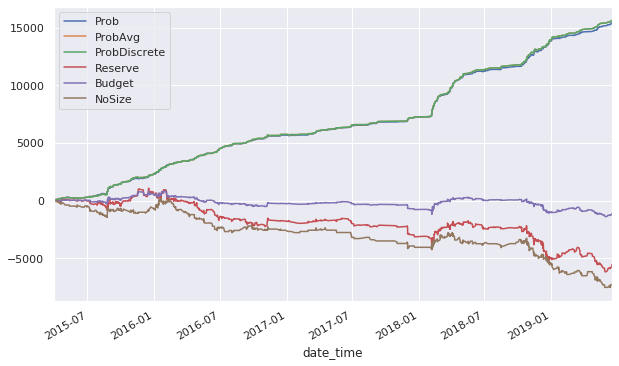

In [461]:
bet_profit.cumsum().plot(figsize=(10,6))

In [474]:
print(X_train.index[0],'부터 ', X_train.index[-1],'까지의 틱 자료의 정보를 이용해', mclose.index[0], '부터 ',mclose.index[-1],'까지의 전략을 세웠다.','\n',
      '전략은 신호가 올 때 마다 1달러 기준으로 계산된 베팅 크기로 사거나 파는 행위를 하는 것이다. 예산은 무한하며 공매도가 가능하다고 가정한다.'
)

2009-10-14 15:29:13 부터  2015-03-30 09:32:47 까지의 틱 자료의 정보를 이용해 2015-03-30 09:42:26 부터  2019-06-18 09:48:22 까지의 전략을 세웠다. 
 전략은 신호가 올 때 마다 1달러 기준으로 계산된 베팅 크기로 사거나 파는 행위를 하는 것이다. 예산은 무한하며 공매도가 가능하다고 가정한다.


결과는 Probability를 기반으로 한 average discrete bet sizing 전략이 가장 많은 수익을 창출한 것으로 나왔다. 

#Backtesting

In [478]:
!pip install -q pyfolio
import pyfolio as pf

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 


In [0]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [0]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

Start date,2015-03-31
End date,2019-06-18
Total months,52
,Backtest
Annual return,-1.2%
Cumulative returns,-5.1%
Annual volatility,2.8%
Sharpe ratio,-0.41
Calmar ratio,-0.13
Stability,0.55
Max drawdown,-9.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.55,2016-01-01,2019-01-03,NaT,NaN
1,1.77,2015-08-27,2015-09-25,2015-10-05,28
2,1.57,2015-03-31,2015-08-07,2015-08-27,108
3,0.50,2015-11-17,2015-12-14,2015-12-17,23
4,0.41,2015-10-22,2015-10-30,2015-11-04,10


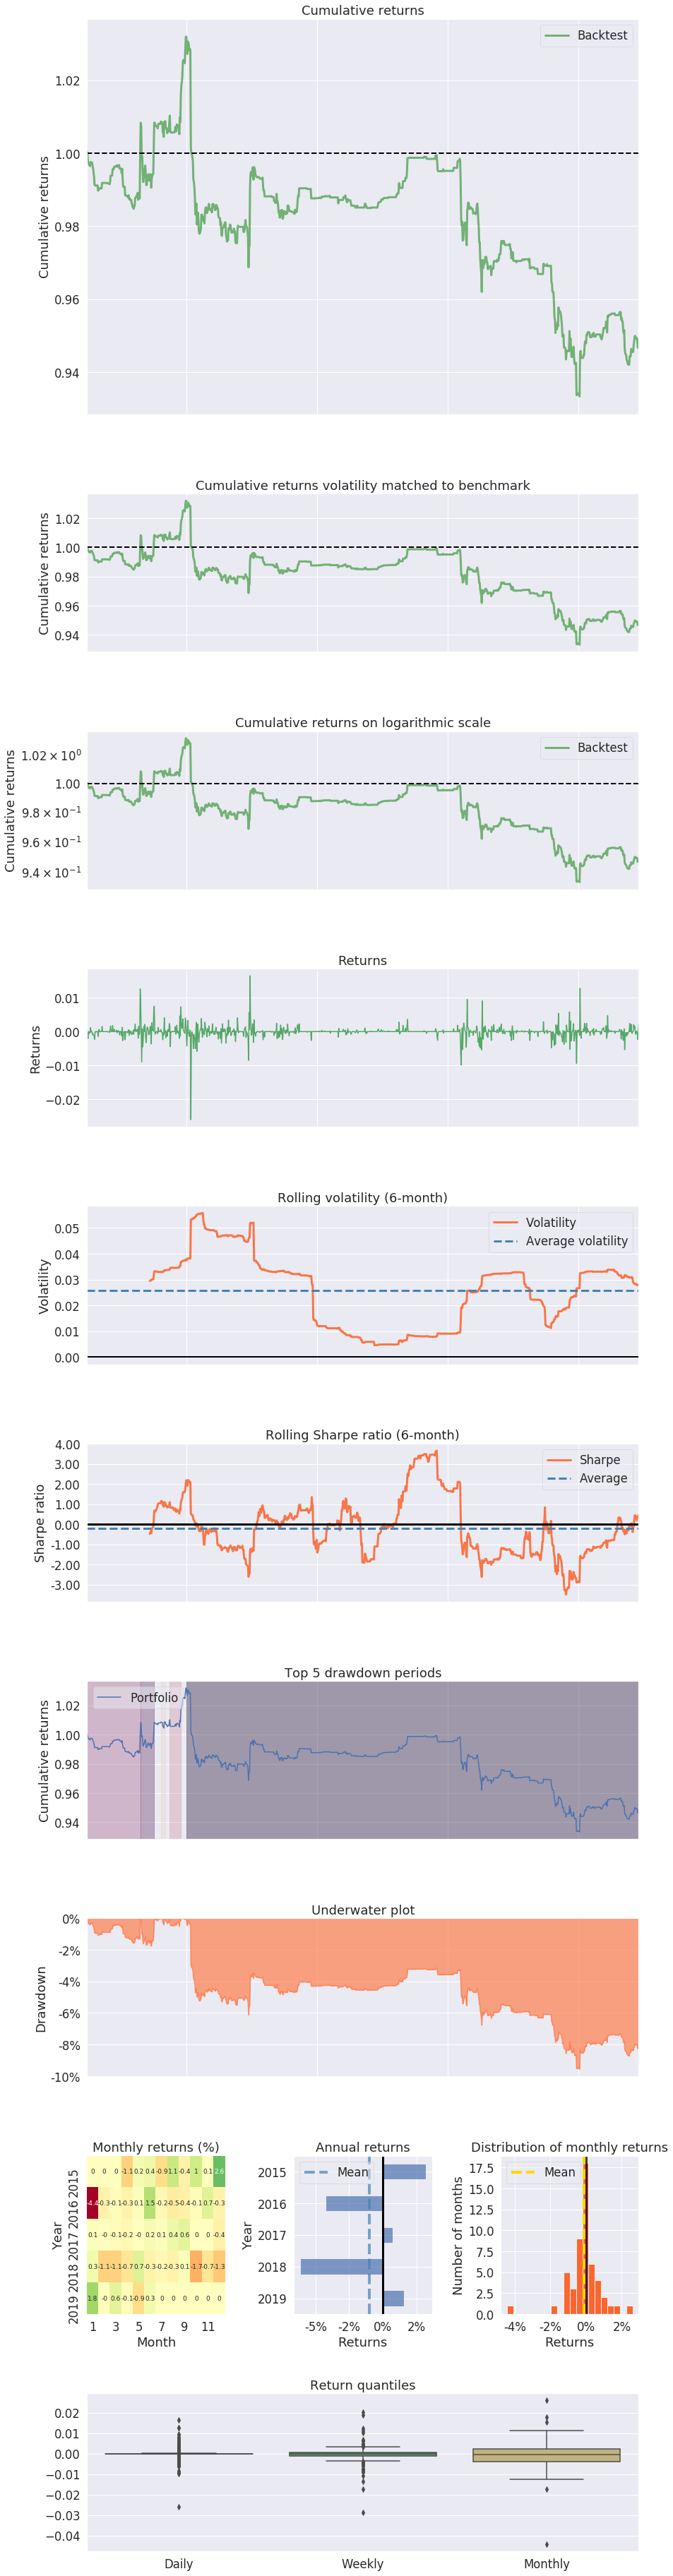

In [484]:
meta_returns = bin.loc[y_test.index, 'ret'] * mprob
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

Start date,2015-03-31
End date,2019-06-18
Total months,52
,Backtest
Annual return,-1.4%
Cumulative returns,-5.9%
Annual volatility,2.7%
Sharpe ratio,-0.50
Calmar ratio,-0.20
Stability,0.53
Max drawdown,-7.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.09,2015-03-31,2018-12-26,NaT,NaN
1,0.00,2015-03-31,2015-03-31,2015-03-31,1
2,0.00,2015-03-31,2015-03-31,2015-03-31,1
3,0.00,2015-03-31,2015-03-31,2015-03-31,1
4,0.00,2015-03-31,2015-03-31,2015-03-31,1


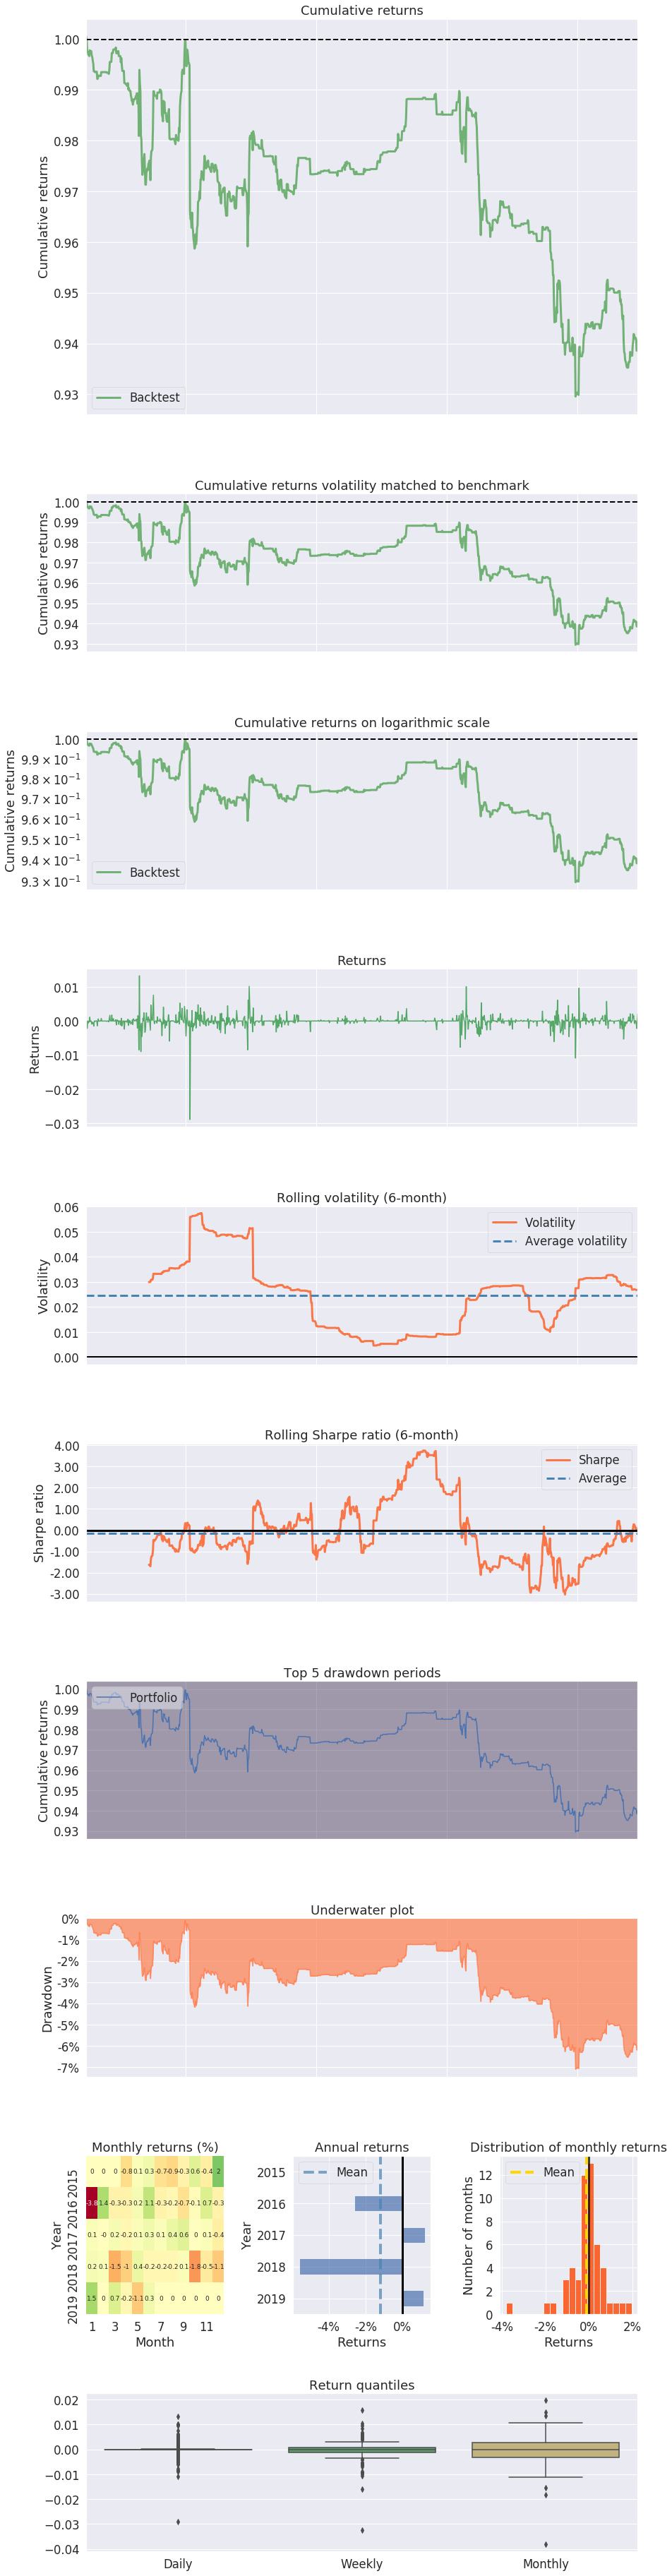

In [485]:
meta_returns = bin.loc[y_test.index, 'ret'] * mproba
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

Start date,2015-03-31
End date,2019-06-18
Total months,52
,Backtest
Annual return,-1.4%
Cumulative returns,-5.9%
Annual volatility,2.7%
Sharpe ratio,-0.50
Calmar ratio,-0.20
Stability,0.52
Max drawdown,-7.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.03,2016-01-01,2018-12-26,NaT,NaN
1,2.80,2015-03-31,2015-09-11,2015-12-31,198
2,0.00,2015-03-31,2015-03-31,2015-03-31,1
3,0.00,2015-03-31,2015-03-31,2015-03-31,1
4,0.00,2015-03-31,2015-03-31,2015-03-31,1


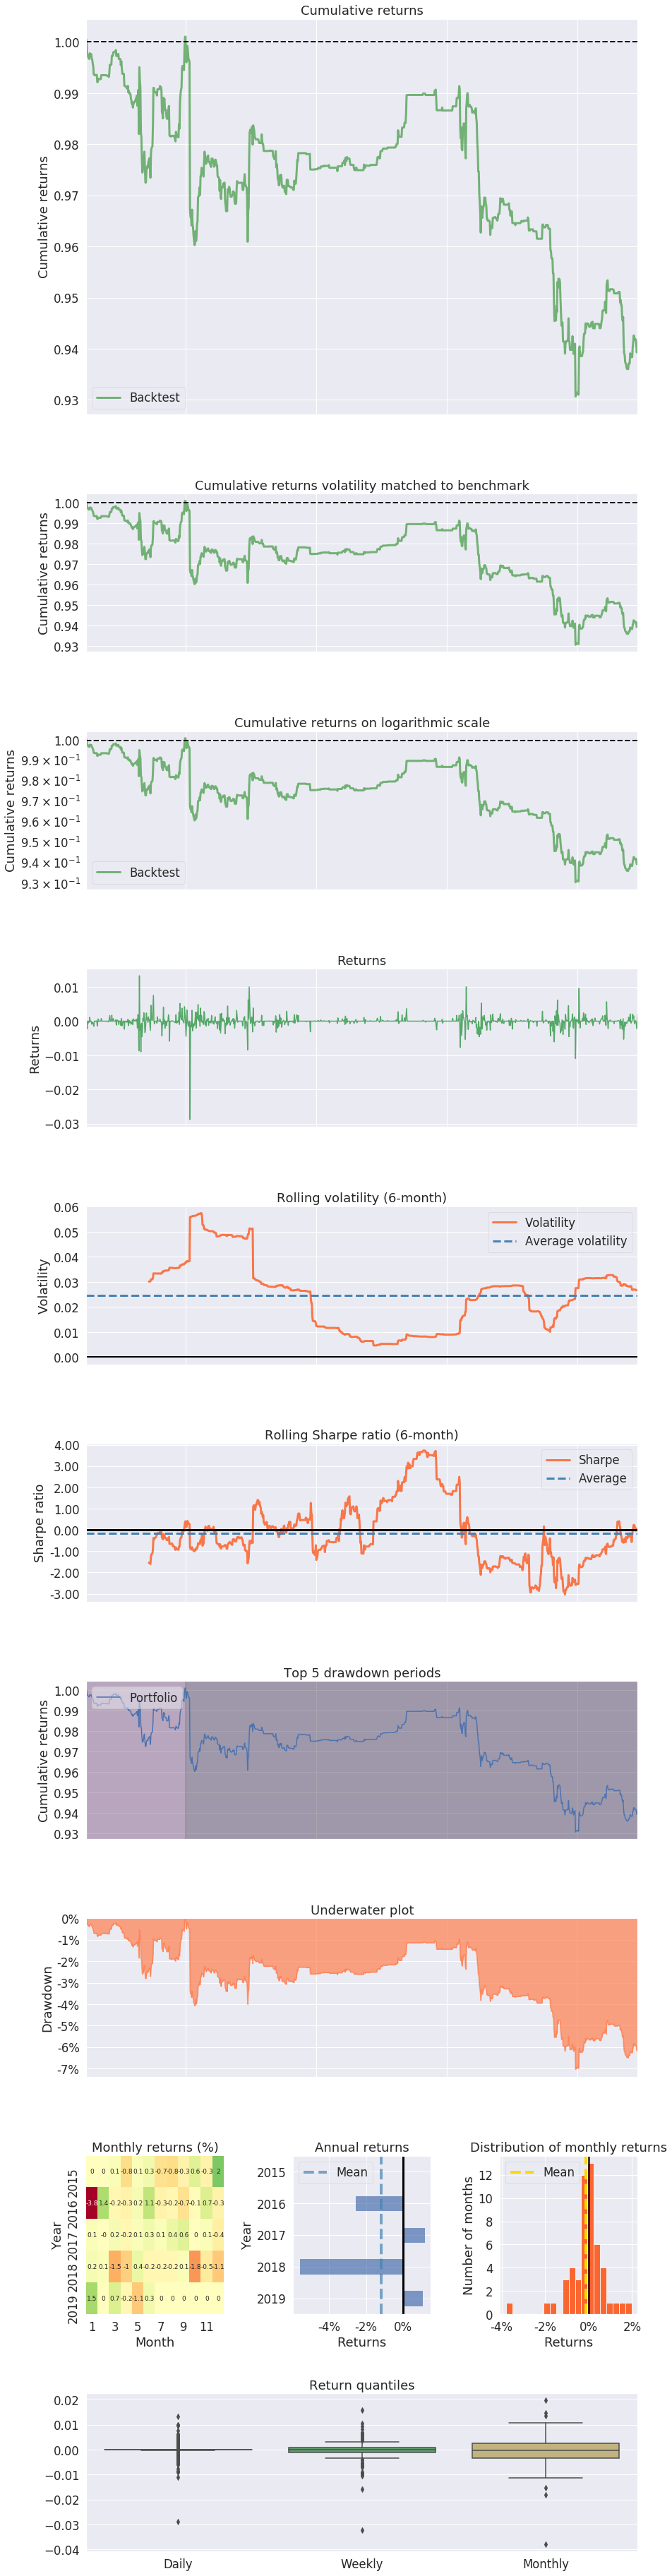

In [486]:
meta_returns = bin.loc[y_test.index, 'ret'] * mprobd
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

Start date,2015-03-31
End date,2019-06-18
Total months,52
,Backtest
Annual return,-5.1%
Cumulative returns,-20.3%
Annual volatility,12.3%
Sharpe ratio,-0.36
Calmar ratio,-0.17
Stability,0.55
Max drawdown,-30.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.61,2015-08-18,2016-02-10,NaT,NaN
1,0.82,2015-04-17,2015-04-23,2015-07-07,58
2,0.69,2015-04-01,2015-04-02,2015-04-14,10
3,0.41,2015-08-10,2015-08-11,2015-08-12,3
4,0.39,2015-08-03,2015-08-06,2015-08-07,5


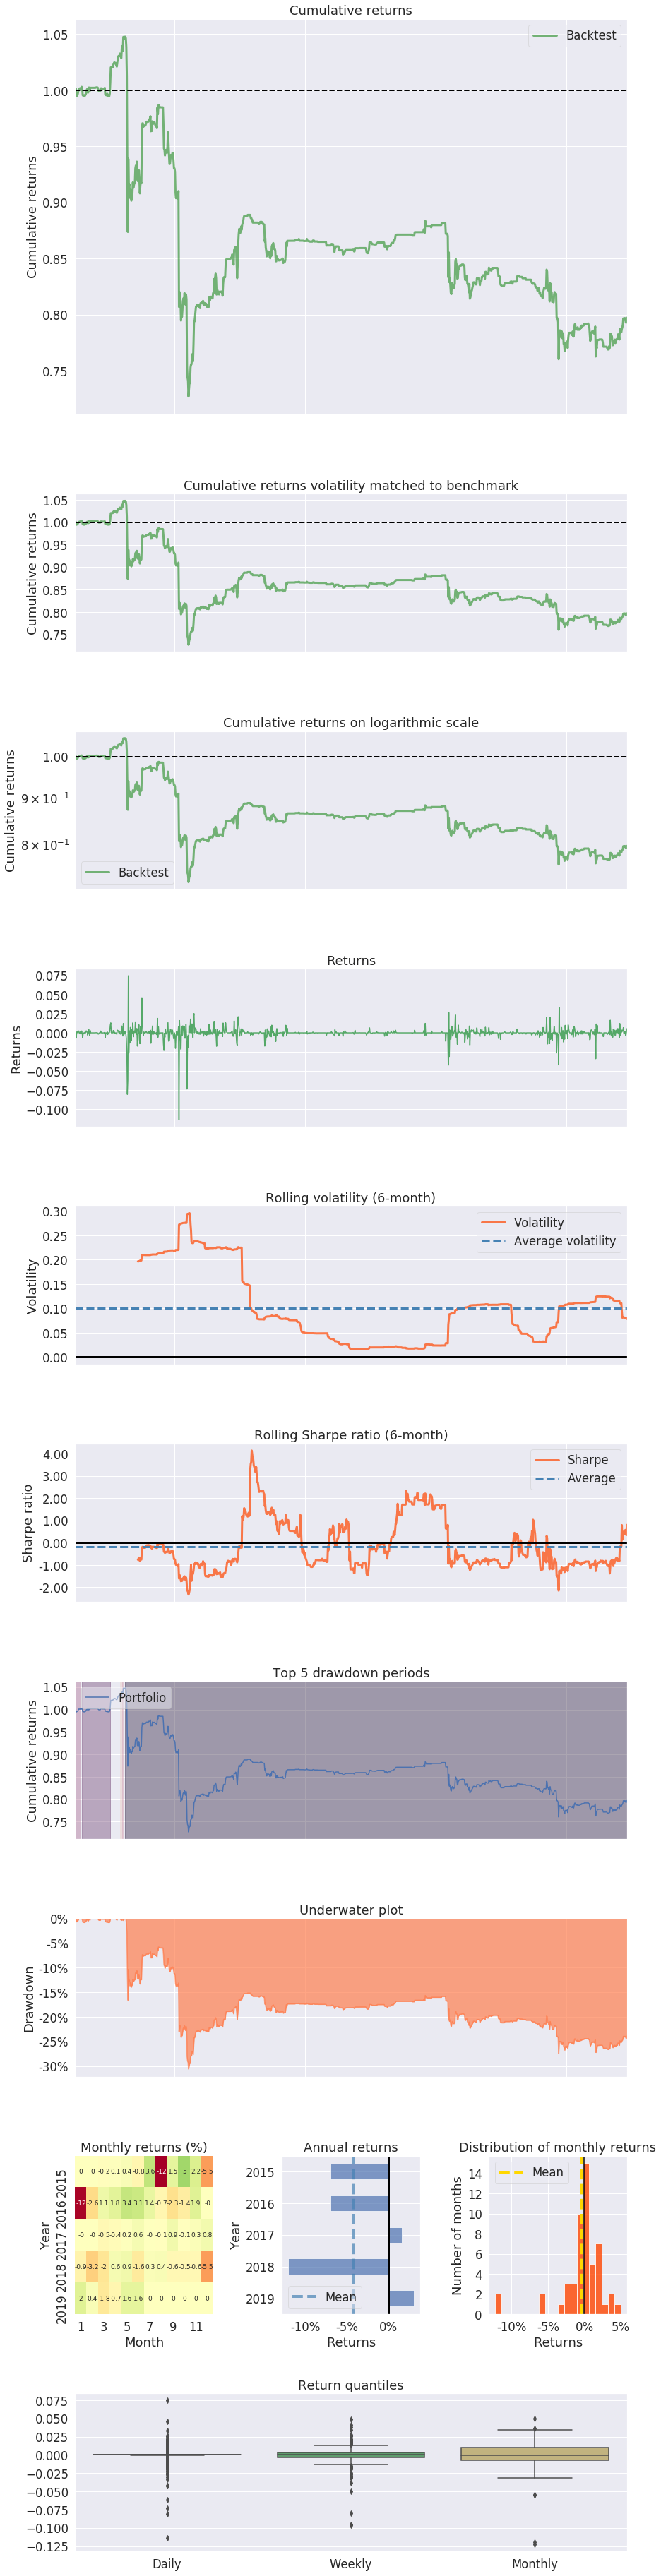

In [487]:
meta_returns = bin.loc[y_test.index, 'ret'] * mres
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

Start date,2015-03-31
End date,2019-06-18
Total months,52
,Backtest
Annual return,-3.5%
Cumulative returns,-14.5%
Annual volatility,6.7%
Sharpe ratio,-0.50
Calmar ratio,-0.18
Stability,0.53
Max drawdown,-19.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.79,2015-08-18,2016-02-10,NaT,NaN
1,0.45,2015-04-17,2015-06-30,2015-07-07,58
2,0.29,2015-04-01,2015-04-02,2015-04-17,13
3,0.16,2015-08-10,2015-08-11,2015-08-12,3
4,0.15,2015-08-03,2015-08-06,2015-08-07,5


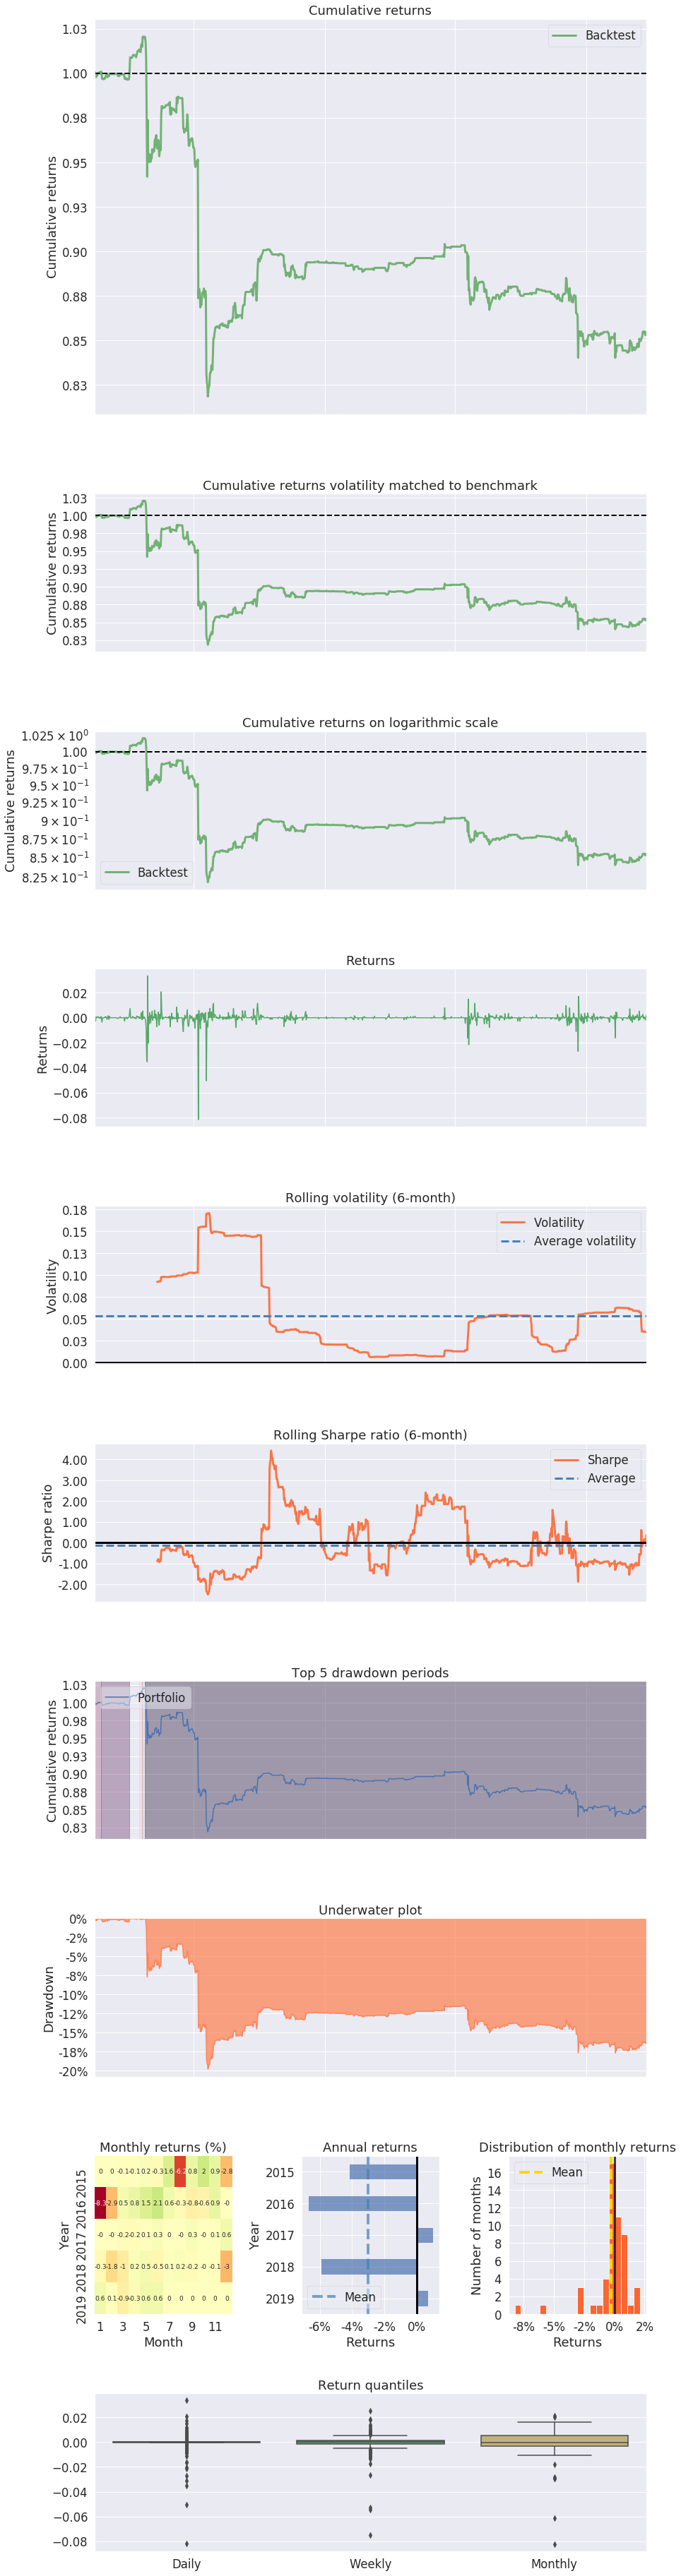

In [488]:
meta_returns = bin.loc[y_test.index, 'ret'] * mbudg
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

Start date,2015-03-31
End date,2019-06-18
Total months,52
,Backtest
Annual return,4.5%
Cumulative returns,21.3%
Annual volatility,11.0%
Sharpe ratio,0.46
Calmar ratio,0.17
Stability,0.39
Max drawdown,-27.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.05,2015-08-24,2016-01-19,2018-12-28,875
1,2.68,2019-05-03,2019-05-09,2019-05-23,15
2,1.19,2019-04-10,2019-04-12,2019-05-02,17
3,1.13,2019-01-14,2019-01-18,2019-01-23,8
4,1.07,2015-04-01,2015-04-02,2015-04-17,13


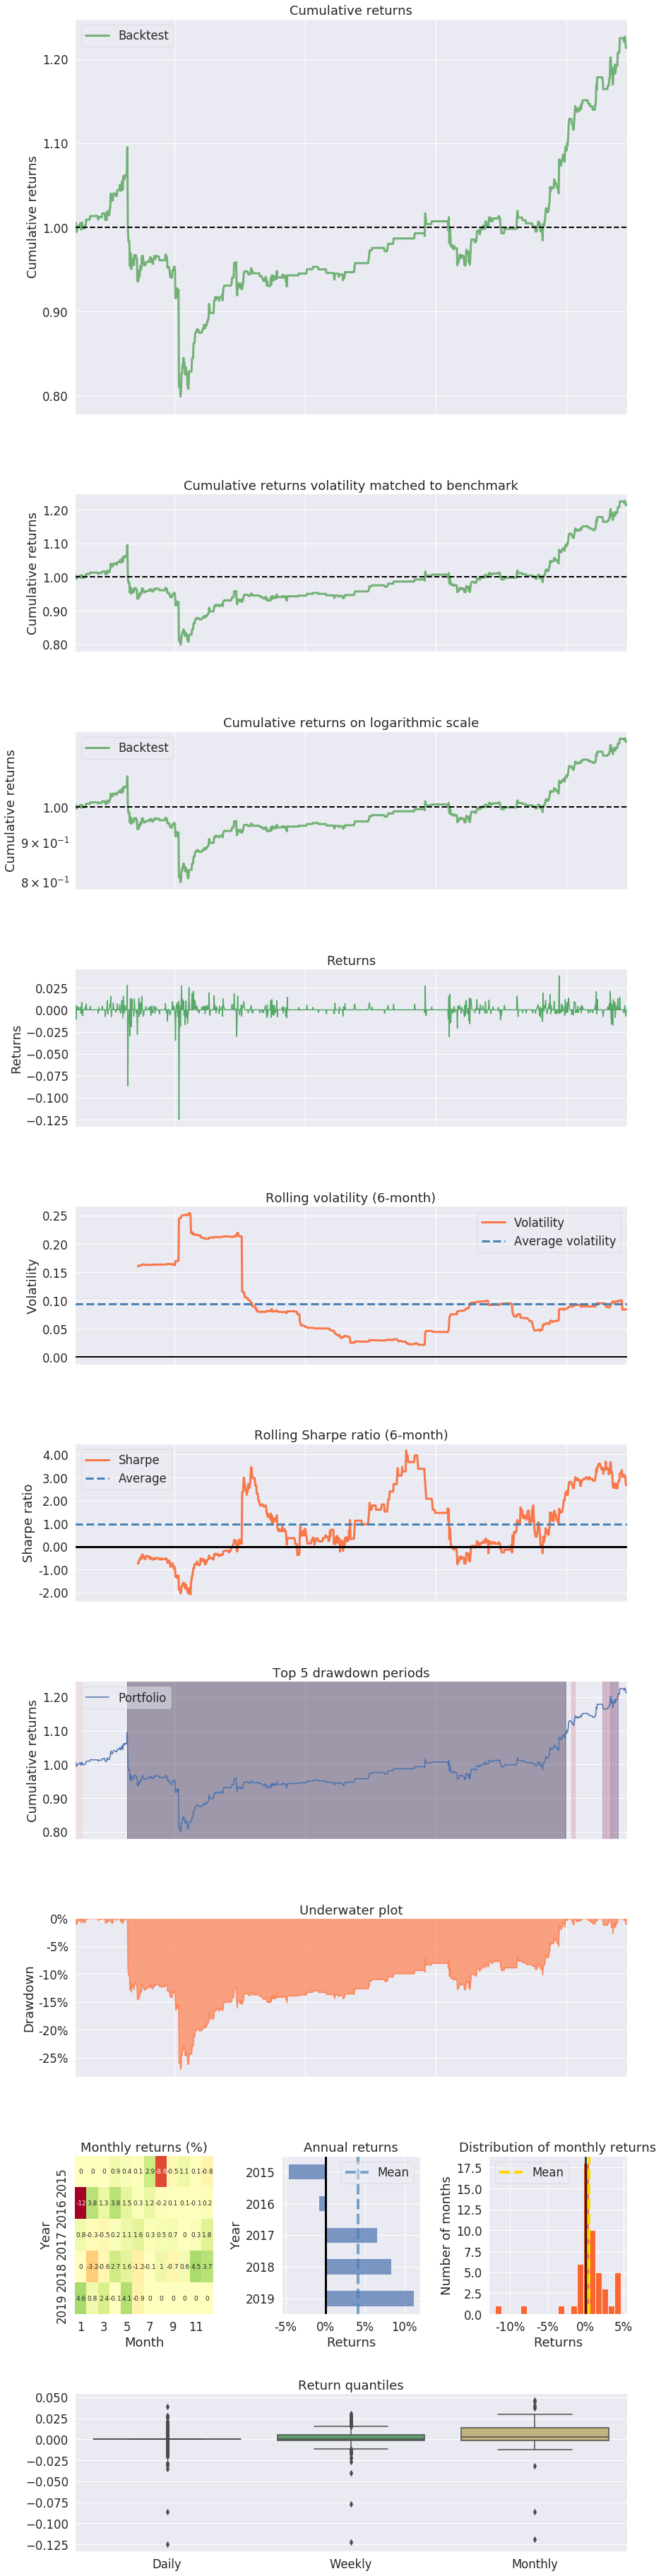

In [489]:
meta_returns = bin.loc[y_test.index, 'ret'] * mnosize
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"
